In [1]:
#required libraries
!pip install scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')



# LOADING FEATURES DATASET


In [2]:
# Load the dataset
df = pd.read_csv('/content/audio_features.csv')
df.columns = df.columns.str.strip()

# Fix the member column - extract from phrase column
df['phrase'] = df['phrase'].str.strip()
df['augmentation'] = df['augmentation'].str.strip()

# Extract member name from phrase (format: "approve - alli")
df['member'] = df['phrase'].str.split(' - ').str[-1]
# Extract actual phrase (format: "approve - alli" -> "approve")
df['phrase_type'] = df['phrase'].str.split(' - ').str[0]

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")
print(f"\nMembers: {df['member'].unique()}")
print(f"Phrase types: {df['phrase_type'].unique()}")
print(f"Augmentations: {df['augmentation'].unique()}")
print(f"\nSamples per member:")
print(df.groupby(['member', 'augmentation']).size())

Dataset loaded: (40, 39)

Columns: ['filename', 'member', 'phrase', 'augmentation', 'mfcc_0_mean', 'mfcc_0_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_2_mean', 'mfcc_2_std']...

Members: ['alli' 'ange' 'elissa' 'terry']
Phrase types: ['approve' 'confirm']
Augmentations: ['original' 'pitch_shift' 'time_stretch' 'add_noise' 'gain']

Samples per member:
member  augmentation
alli    add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
ange    add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
elissa  add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
terry   add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
dtype: int64


# DATA EXPLORATION


 DATA:

Total samples: 40
Samples per member:
member  augmentation
alli    add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
ange    add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
elissa  add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
terry   add_noise       2
        gain            2
        original        2
        pitch_shift     2
        time_stretch    2
dtype: int64


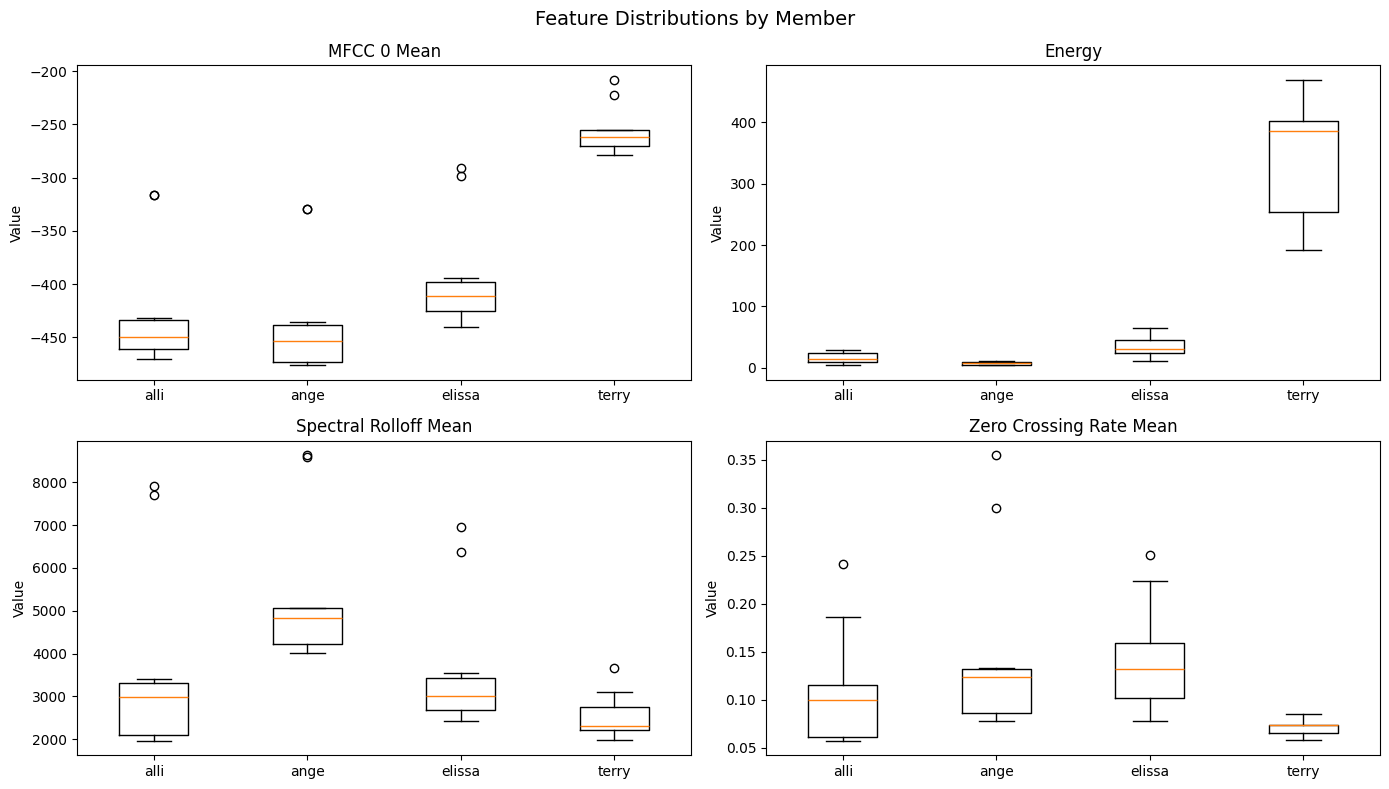

In [3]:
print("\n DATA:")
print(f"\nTotal samples: {len(df)}")
print(f"Samples per member:")
print(df.groupby(['member', 'augmentation']).size())

# Get unique members for plotting
members = sorted(df['member'].unique())

# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Feature Distributions by Member', fontsize=14)

# MFCC mean distribution
axes[0, 0].boxplot([df[df['member'] == member]['mfcc_0_mean'].values
                     for member in members],
                    labels=members)
axes[0, 0].set_title('MFCC 0 Mean')
axes[0, 0].set_ylabel('Value')

# Energy distribution
axes[0, 1].boxplot([df[df['member'] == member]['energy'].values
                     for member in members],
                    labels=members)
axes[0, 1].set_title('Energy')
axes[0, 1].set_ylabel('Value')

# Spectral rolloff distribution
axes[1, 0].boxplot([df[df['member'] == member]['spectral_rolloff_mean'].values
                     for member in members],
                    labels=members)
axes[1, 0].set_title('Spectral Rolloff Mean')
axes[1, 0].set_ylabel('Value')

# Zero crossing rate distribution
axes[1, 1].boxplot([df[df['member'] == member]['zcr_mean'].values
                     for member in members],
                    labels=members)
axes[1, 1].set_title('Zero Crossing Rate Mean')
axes[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

# PREPARE DATA FOR MODELING

In [4]:
# Drop non-feature columns
feature_cols = [col for col in df.columns if col not in
                ['filename', 'member', 'phrase', 'augmentation', 'phrase_type']]

X = df[feature_cols].values
y_member = df['member'].values
y_phrase = df['phrase_type'].values

# Encode members and phrases
from sklearn.preprocessing import LabelEncoder
le_member = LabelEncoder()
le_phrase = LabelEncoder()

y_member_encoded = le_member.fit_transform(y_member)
y_phrase_encoded = le_phrase.fit_transform(y_phrase)

print(f"\n=== DATA PREPARATION ===")
print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"Member classes: {dict(zip(le_member.classes_, le_member.transform(le_member.classes_)))}")
print(f"Phrase classes: {dict(zip(le_phrase.classes_, le_phrase.transform(le_phrase.classes_)))}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


=== DATA PREPARATION ===
Feature matrix shape: (40, 34)
Number of features: 34
Member classes: {'alli': np.int64(0), 'ange': np.int64(1), 'elissa': np.int64(2), 'terry': np.int64(3)}
Phrase classes: {'approve': np.int64(0), 'confirm': np.int64(1)}


# TRAIN MEMBER IDENTIFICATION MODEL

Random Forest Accuracy: 1.0000
SVM Accuracy: 1.0000

=== MEMBER IDENTIFICATION CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        alli       1.00      1.00      1.00         2
        ange       1.00      1.00      1.00         2
      elissa       1.00      1.00      1.00         2
       terry       1.00      1.00      1.00         2

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



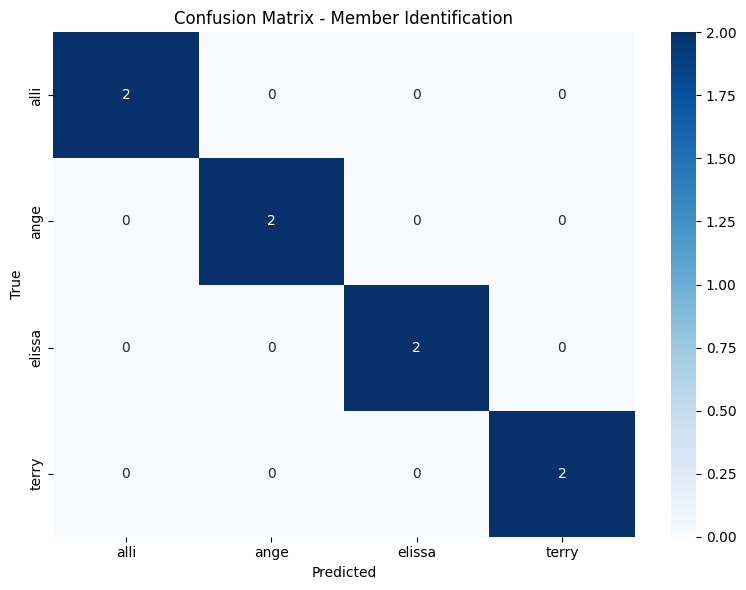

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_member_encoded, test_size=0.2, random_state=42, stratify=y_member_encoded
)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# Train SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Use Random Forest as primary model
print("\n=== MEMBER IDENTIFICATION CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_rf,
                            target_names=le_member.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le_member.classes_,
            yticklabels=le_member.classes_)
plt.title('Confusion Matrix - Member Identification')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# DEVELOPING VOICEPRINT EMBEDDINGS

In [6]:
def create_voiceprint_embedding(features_row, scaler):
    """Create normalized embedding from features"""
    scaled = scaler.transform([features_row])[0]
    # Normalize to unit vector for similarity comparison
    norm = np.linalg.norm(scaled)
    if norm > 0:
        scaled = scaled / norm
    return scaled

# Create embeddings for all samples (only original, non-augmented)
original_samples = df[df['augmentation'] == 'original'].copy()
embeddings = {}

for idx, row in original_samples.iterrows():
    member = row['member']
    features = row[feature_cols].values
    embedding = create_voiceprint_embedding(features, scaler)

    if member not in embeddings:
        embeddings[member] = []
    embeddings[member].append(embedding)

# Calculate mean voiceprint per member
voiceprints = {}
for member, emb_list in embeddings.items():
    voiceprints[member] = np.mean(emb_list, axis=0)
    print(f"Voiceprint created for {member} (embedding size: {len(voiceprints[member])})")

Voiceprint created for alli (embedding size: 34)
Voiceprint created for ange (embedding size: 34)
Voiceprint created for elissa (embedding size: 34)
Voiceprint created for terry (embedding size: 34)


# VOICEPRINT VERIFICATION SYSTEM

In [7]:
print("\n=== VOICEPRINT VERIFICATION ===")

def verify_voiceprint(test_features, member_name, voiceprints, scaler, threshold=0.7):
    """Verify if test features match member's voiceprint"""
    test_embedding = create_voiceprint_embedding(test_features, scaler)

    # Compare with claimed member
    claimed_voiceprint = voiceprints[member_name]
    similarity = cosine_similarity([test_embedding], [claimed_voiceprint])[0][0]

    is_verified = similarity >= threshold

    return {
        'member': member_name,
        'similarity': similarity,
        'verified': is_verified,
        'threshold': threshold
    }

def identify_speaker(test_features, voiceprints, scaler):
    """Identify speaker from test features"""
    test_embedding = create_voiceprint_embedding(test_features, scaler)

    similarities = {}
    for member, voiceprint in voiceprints.items():
        sim = cosine_similarity([test_embedding], [voiceprint])[0][0]
        similarities[member] = sim

    best_member = max(similarities, key=similarities.get)
    best_score = similarities[best_member]

    return best_member, best_score, similarities


=== VOICEPRINT VERIFICATION ===


# TEST VERIFICATION

In [14]:
print("\n=== TESTING VERIFICATION ON AUGMENTED DATA ===")

test_samples = df[df['augmentation'] != 'original'].copy()
verification_results = []

for idx, row in test_samples.iterrows():
    member = row['member']
    features = row[feature_cols].values

    # Test 1: Verify correct member
    result = verify_voiceprint(features, member, voiceprints, scaler, threshold=0.65)
    result['test_type'] = 'correct_member'
    verification_results.append(result)

    # Test 2: Try to identify speaker
    identified, score, all_scores = identify_speaker(features, voiceprints, scaler)
    verification_results.append({
        'member': member,
        'identified_as': identified,
        'confidence': score,
        'test_type': 'identification',
        'correct': identified == member
    })

# Analysis
verification_df = pd.DataFrame(verification_results)

print("\n=== VERIFICATION RESULTS ===")
print(f"Correct Member Verification Rate: {verification_df[verification_df['test_type'] == 'correct_member']['verified'].mean():.2%}")
print(f"Speaker Identification Accuracy: {verification_df[verification_df['test_type'] == 'identification']['correct'].mean():.2%}")


=== TESTING VERIFICATION ON AUGMENTED DATA ===

=== VERIFICATION RESULTS ===
Correct Member Verification Rate: 3.12%
Speaker Identification Accuracy: 87.50%



=== SIMILARITY MATRIX ===


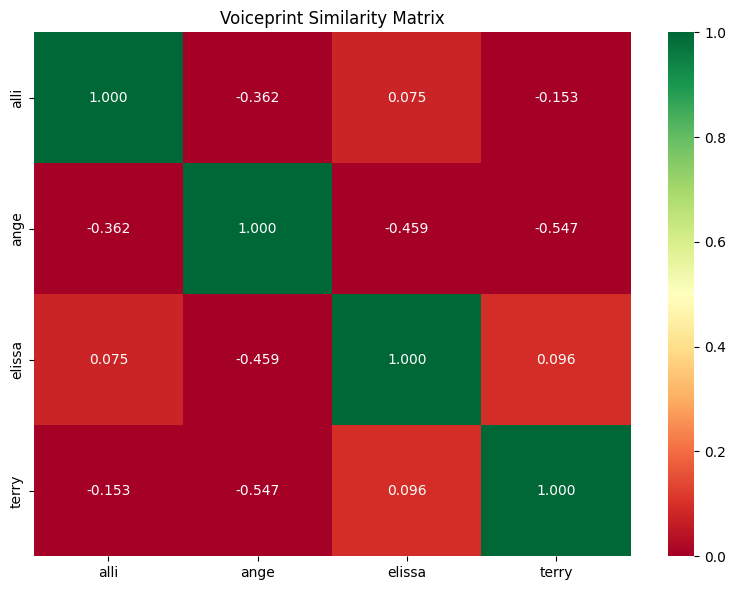

In [15]:
# ============ SIMILARITY HEATMAP ============
print("\n=== SIMILARITY MATRIX ===")

similarity_matrix = np.zeros((len(voiceprints), len(voiceprints)))
members_list = list(voiceprints.keys())

for i, member_i in enumerate(members_list):
    for j, member_j in enumerate(members_list):
        sim = cosine_similarity([voiceprints[member_i]], [voiceprints[member_j]])[0][0]
        similarity_matrix[i, j] = sim

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=members_list, yticklabels=members_list,
            vmin=0, vmax=1)
plt.title('Voiceprint Similarity Matrix')
plt.tight_layout()
plt.show()

In [10]:
# ============ SAVE MODELS ============
import pickle

# Save voiceprints, scaler, and models
with open('voiceprints.pkl', 'wb') as f:
    pickle.dump(voiceprints, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump({'member': le_member, 'phrase': le_phrase}, f)

print("\n Models and voiceprints saved!")
print("  - voiceprints.pkl")
print("  - scaler.pkl")
print("  - rf_model.pkl")
print("  - label_encoders.pkl")



 Models and voiceprints saved!
  - voiceprints.pkl
  - scaler.pkl
  - rf_model.pkl
  - label_encoders.pkl


In [11]:
# ============ PREDICTION INTERFACE ============
print("\n=== READY FOR DEPLOYMENT ===")
print("""
To use the verification system:

1. Load a new audio file and extract features using the feature extraction pipeline
2. Use verify_voiceprint() for identity verification
3. Use identify_speaker() for speaker identification
4. Adjust threshold based on your security requirements (higher = stricter)
""")

# Example usage - check if members exist
available_members = df['member'].unique()
print(f"\nAvailable members: {list(available_members)}")

if len(available_members) > 0:
    # Use first available member for example
    test_member = available_members[0]
    test_samples = df[(df['member'] == test_member) & (df['augmentation'] == 'pitch_shift')]

    if len(test_samples) > 0:
        print(f"\nExample: Verify test sample against member '{test_member}':")
        test_row = test_samples.iloc[0]
        test_features = test_row[feature_cols].values
        result = verify_voiceprint(test_features, test_member, voiceprints, scaler, threshold=0.65)
        print(f"Result: {result}")
    else:
        print(f"\nNo pitch_shift samples found for {test_member}")
else:
    print("\nNo members found in dataset")


=== READY FOR DEPLOYMENT ===

To use the verification system:

1. Load a new audio file and extract features using the feature extraction pipeline
2. Use verify_voiceprint() for identity verification
3. Use identify_speaker() for speaker identification
4. Adjust threshold based on your security requirements (higher = stricter)


Available members: ['alli', 'ange', 'elissa', 'terry']

Example: Verify test sample against member 'alli':
Result: {'member': 'alli', 'similarity': np.float64(0.315273632393511), 'verified': np.False_, 'threshold': 0.65}
